In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A simple simulation experimental setup:
$$f(x)=x\log x,\;x\in[0,1],\;X|Y=y \sim \textrm{Beta}(\alpha(y),\beta(y)).$$
$f$ has a minimum at $x=1/e$ (no local minima). We can compute
$$g(y)=\mathbb E_{X|Y=y}\left[X\log X\right]=\frac{\alpha(y)}{\alpha(y)+\beta(y)}\left[\psi(\alpha(y)+1)-\psi(\alpha(y)+\beta(y)+1)\right],$$
where $\psi$ is the digamma function. To complete the setup need to choose some functions $\alpha:\mathcal Y\to (0,+\infty)$, $\beta:\mathcal Y\to (0,+\infty),$ e.g. take $\mathcal Y=\mathbb R^3$ and
$$\alpha(y)=\exp(a^\top y+c),\;\beta(y)=\exp(b^\top y+d),$$
or similar.

Nb. the bounded domain of $X$ might need to be built into the kernel construction when estimating CME $X|Y$, e.g. one can use
$$k(x,x')=\exp\left(-\frac{1}{2\gamma^2}\left(\log\frac{x}{1-x}-\log\frac{x'}{1-x'}\right)^2\right),\quad x,x'\in(0,1).$$


In [2]:
def alpha(y,a=1,c=0):
    return np.exp(a * y +c)

def beta(y, b=1, d=0):
    return np.exp(b* y + d)

def func(x):
    return x * np.log(x)

def g(y,a=1,b=0,c=1,d=0):
    alpha_value = alpha(y,a,c)
    beta_value = beta(y,b,d)
    g_value = alpha_value/(alpha_value+beta_value) * (digamma(alpha_value + 1) - digamma(alpha_value + beta_value + 1))
    return g_value

In [3]:
def generate_D1(n, a,b,c,d):
    ys = np.random.uniform(0,1,n)
    alphas = []
    betas = []
    xs = []
    fs = []
    for i in ys:
        alpha_value = alpha(i,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(i,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
    plt.plot(ys, xs, '.')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title('D1')
    
    plt.legend()
    return np.asarray(xs), np.asarray(ys)
    

def generate_D2(m, a,b,c,d, sigma=0.01, plot=True):
    ys = np.random.uniform(0,1,m)
    zs = []
    
    alphas = []
    betas = []
    xs = []
    fs = []
    for y in ys:
        alpha_value = alpha(y,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(y,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
        fs.append(func(x_value))  
        
        g_value = g(y, a,b,c,d)
        z_value = g_value + np.random.normal(0, sigma)
        zs.append(z_value)
        
    if plot:    
        # plt.plot(ys, xs, '.', label = 'x')
        # plt.plot(fs, xs, '.', label = 'f(x)')
        
        plt.plot(ys, zs,'.')
        plt.xlabel('y')
        plt.ylabel('z (aggregated feedback)')
        plt.title('D2')
        
    return np.asarray(ys), np.asarray(zs)

In [4]:
a = 0.1
b = 4
c = 2
d = 0
sigma = 0.01

In [5]:
# a = 1
# b = 4
# c = 0
# d = 1

No handles with labels found to put in legend.


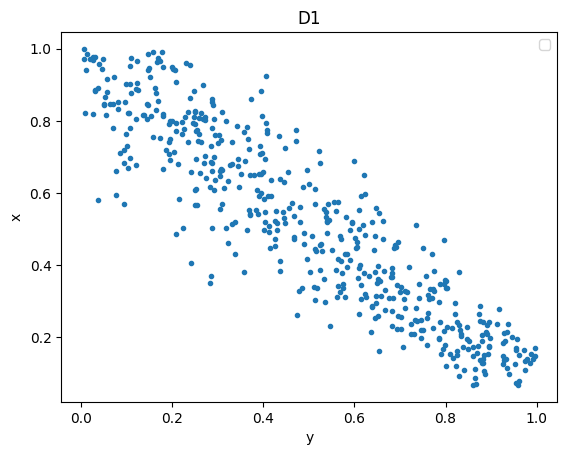

In [6]:
xs, ys = generate_D1(500,a,b,c,d)

Text(0, 0.5, 'f(x)')

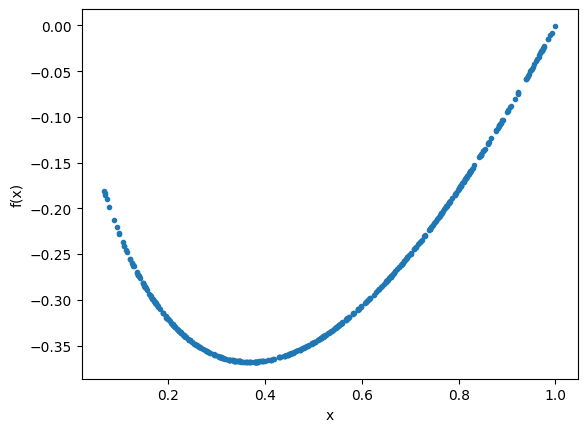

In [7]:
plt.plot(xs, func(xs), '.')
plt.xlabel('x')
plt.ylabel('f(x)')

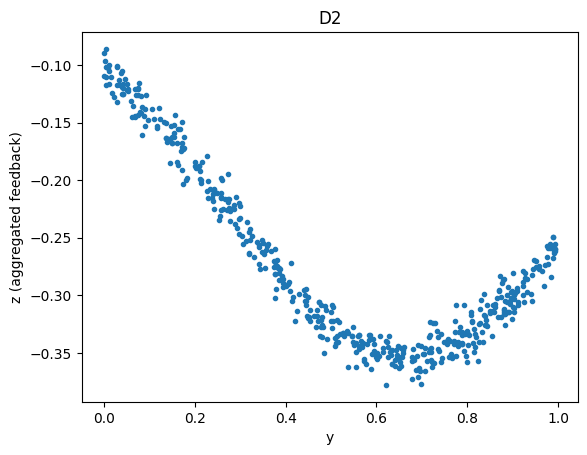

In [8]:
ys2, zs = generate_D2(500, a,b,c,d, sigma)

In [9]:
muz, sigmaz = zs.mean(), zs.std()
zs = (zs - muz) / sigmaz

In [10]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys))
model = build_model(cfg['model'])

In [11]:
groundtruth_individuals = torch.tensor(np.linspace(1e-5,1-1e-5,150)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [12]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

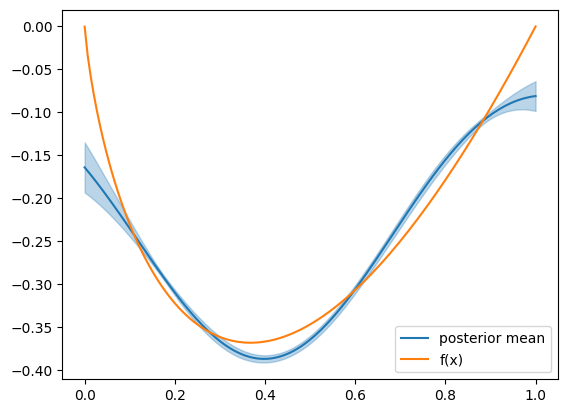

In [13]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [14]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(0.3691)

In [15]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(0.3960)

# PES

In [16]:
ys = torch.from_numpy(ys).float()

In [17]:
predict_kwargs = {'name': cfg['model']['name'],
                  'model': model.eval().cpu(),
                  'individuals': torch.from_numpy(xs).float()}
xs_posterior = predict(predict_kwargs)

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")


In [18]:
# calculate eq 12

with torch.no_grad():
    Kd = sigmaz**2 * xs_posterior.covariance_matrix
    print(Kd.shape)

    N = len(ys)
    λ = 0.01
    Lλ = model.bag_kernel(ys, ys).add_diag(λ * N * torch.ones(N))
    chol = torch.linalg.cholesky(Lλ.evaluate())
    
    Lys_ys2 = model.bag_kernel(ys, groundtruth_individuals).evaluate()
    Lλinv_Lys_ys2 = torch.cholesky_solve(Lys_ys2, chol)
    
    B = Lλinv_Lys_ys2.T @ Kd @ Lλinv_Lys_ys2 # this is the term in (12)
    
    entropy_z_given_y = 0.5 * np.log(2 * np.pi * np.e * (B + sigma ** 2))

torch.Size([500, 500])


torch.Size([150, 150])


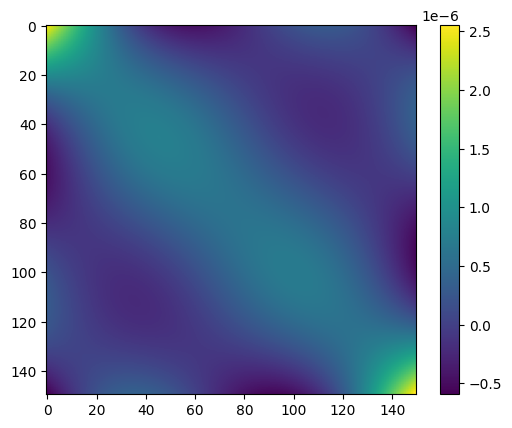

In [19]:
print(B.shape)
plt.imshow(B)
plt.colorbar()

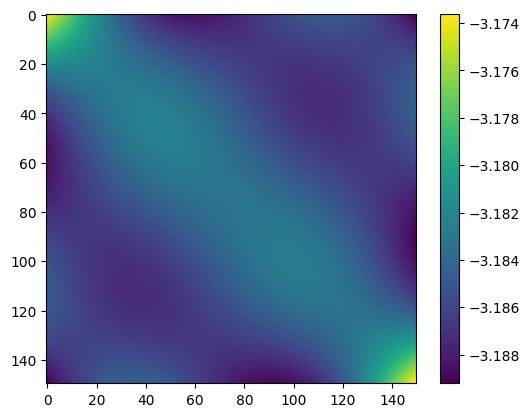

In [20]:
plt.imshow(entropy_z_given_y)
plt.colorbar()

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


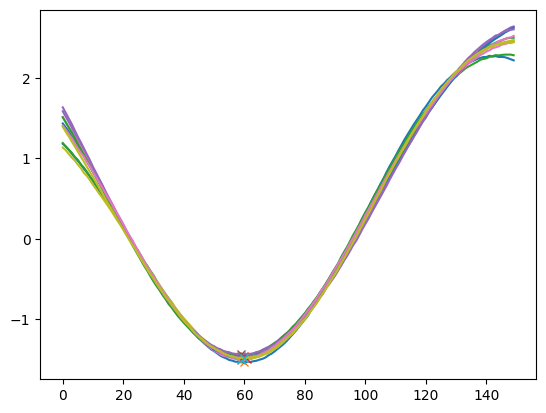

In [21]:
for _ in range(10):
    pos_sample = individuals_posterior.sample()
    opt = torch.min(pos_sample)
    x_opt = np.argmin(pos_sample)
    plt.plot(pos_sample)
    plt.plot(x_opt, opt, 'x')

In [22]:
x_nob = individuals_posterior.covariance_matrix

In [24]:
# from src.pes.compute_covariance import *

# UCB

Text(0, 0.5, 'y')

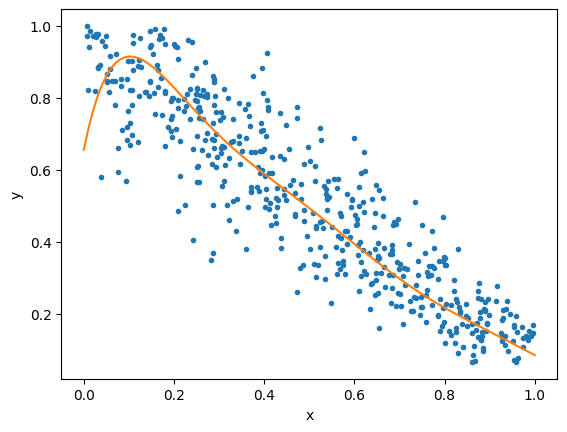

In [25]:
# predict using sklearn

xs = xs.reshape(-1,1)
ys = ys.reshape(-1,1)
pred_space = np.linspace(0,1,100).reshape(-1,1)
gpr_x_y = GaussianProcessRegressor(random_state=0).fit(xs,ys)
mean, std = gpr_x_y.predict(pred_space, return_std=True)
plt.plot(ys,xs,'.')
plt.plot(pred_space,mean)
plt.fill_between(pred_space.reshape(-1,), mean+2*std, mean-2*std)
plt.xlabel('x')
plt.ylabel('y')

In [35]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

xs = xs.reshape(-1,)
ys = ys.reshape(-1,)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(torch.tensor(xs).float(), torch.tensor(ys).float(), likelihood)
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(torch.tensor(xs).float())
    # Calc loss and backprop gradients
    loss = -mll(output, torch.tensor(ys).float())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

/var/folders/0f/74t0_jrd7cg6w0svtvz1s8cm0000gp/T/ipykernel_66680/2657140634.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model = ExactGPModel(torch.tensor(xs).float(), torch.tensor(ys).float(), likelihood)
/var/folders/0f/74t0_jrd7cg6w0svtvz1s8cm0000gp/T/ipykernel_66680/2657140634.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = -mll(output, torch.tensor(ys).float())


Iter 1/50 - Loss: 0.758   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.722   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.685   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.647   lengthscale: 0.851   noise: 0.554
Iter 5/50 - Loss: 0.609   lengthscale: 0.905   noise: 0.513
Iter 6/50 - Loss: 0.571   lengthscale: 0.955   noise: 0.474
Iter 7/50 - Loss: 0.532   lengthscale: 0.998   noise: 0.437
Iter 8/50 - Loss: 0.492   lengthscale: 1.031   noise: 0.403
Iter 9/50 - Loss: 0.452   lengthscale: 1.051   noise: 0.370
Iter 10/50 - Loss: 0.411   lengthscale: 1.057   noise: 0.340
Iter 11/50 - Loss: 0.370   lengthscale: 1.052   noise: 0.312
Iter 12/50 - Loss: 0.328   lengthscale: 1.037   noise: 0.286
Iter 13/50 - Loss: 0.286   lengthscale: 1.016   noise: 0.262
Iter 14/50 - Loss: 0.243   lengthscale: 0.990   noise: 0.239
Iter 15/50 - Loss: 0.200   lengthscale: 0.963   noise: 0.218
Iter 16/50 - Loss: 0.157   lengthscale: 0.937   noise: 0.199
Iter 17/50 - Loss: 0.114   length

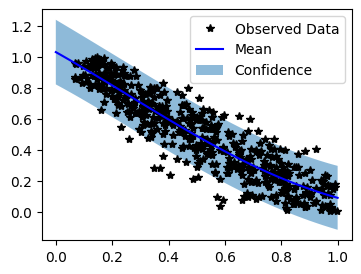

In [36]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.tensor(np.linspace(0, 1, 100)).float()
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(xs, ys, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [37]:
def g_oracle(y, sigma=0.01):
    g_value = g(y)
    z_value = g_value + np.random.normal(0, sigma)
    return z_value

x_space = np.linspace(1e-5,1-1e-5,100)
y_space = np.linspace(1e-5,1-1e-5,100)
init_y_size = 3
num_round = 100
num_repeat = 10

In [ ]:
from BO import BayesOpt_UCB, BayesOpt_Random

pos_best_dict = {}
agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/')
pos_best_dict['ucb'] = agent_ucb.simulation()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
100%|██████████| 10/10 [44:12<00:00, 265.25s/it]


In [ ]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/')
pos_best_dict['random']= agent_random.simulation()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
100%|██████████| 10/10 [47:07<00:00, 282.72s/it]


In [ ]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.min(func(x_space))
        regret_mean = np.abs(opt - pos_bests).mean(axis=0)
        regret_std = np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  

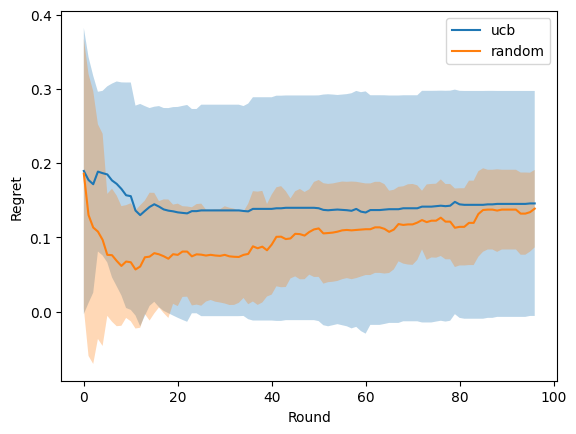

In [ ]:
evalaution(pos_best_dict)

In [ ]:
pos_best_dict['ucb'][0]


[-0.1135563002699915,
 -0.15605431285252047,
 -0.18008630976824355,
 -0.18784337305397772,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18784337305397772,
 -0.18784337305397772,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18784337305397772,
 -0.18784337305397772,
 -0.18784337305397772,
 -0.18784337305397772,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630976824355,
 -0.18008630

In [ ]:
pos_best_dict['ucb'][1]

[-0.32654860518154954,
 -0.2983749875416931,
 -0.27624037664336193,
 -0.21033079445405342,
 -0.19547093689626188,
 -0.19547093689626188,
 -0.19547093689626188,
 -0.224651885495831,
 -0.27031205384674917,
 -0.27624037664336193,
 -0.282013298629044,
 -0.282013298629044,
 -0.287628391507582,
 -0.287628391507582,
 -0.287628391507582,
 -0.24509081261289026,
 -0.2516178792501906,
 -0.2579985543401677,
 -0.2579985543401677,
 -0.2579985543401677,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.26423068494321067,
 -0.2

In [ ]:
# np.save('pos-seed24.npy', pos_best_dict)